In [47]:
import os
import re
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

from fuzzywuzzy import process
from sentence_transformers import SentenceTransformer

DATA VISUALIZATION: News Categories

In [49]:
# Load and preview the dataset
news = pd.read_json("Data/news.json", lines=True)
news['content'] = (news['headline'] + " " + news['short_description']).fillna('')

news.shape
news.columns


Index(['link', 'headline', 'category', 'short_description', 'authors', 'date',
       'content'],
      dtype='object')

In [51]:

# Combine headline and short description for each article
news['content'] = news['headline'] + " " + news['short_description']

# Fill any missing values just in case
news['content'] = news['content'].fillna('')

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(news['headline']) 

# Transform the content into TF-IDF features
tfidf_matrix = tfidf.fit_transform(news['content'])

# Check the shape (articles x keywords)
print(tfidf_matrix.shape)


(209527, 88200)


In [39]:

# Fit NearestNeighbors on the TF-IDF matrix
nn_model = NearestNeighbors(metric='cosine', algorithm='brute')
nn_model.fit(tfidf_matrix)


NearestNeighbors(algorithm='brute', metric='cosine')

In [40]:
# Create a mapping of headlines to index (in lowercase for robustness)
indices = pd.Series(news.index, index=news['headline'].str.lower()).drop_duplicates()

def get_recommendations_nn(title, top_n=5):
    title_lower = title.lower()
    idx = indices.get(title_lower)
    if idx is None:
        return ["Title not found."]
    
    # Get top N+1 neighbors (includes the article itself)
    distances, indices_nn = nn_model.kneighbors(tfidf_matrix[idx], n_neighbors=top_n + 1)
    
    # Exclude the article itself (distance=0)
    recommended_indices = indices_nn[0][1:]
    
    return news['headline'].iloc[recommended_indices].tolist()

get_recommendations_nn("Trump Signs New Trade Deal With China", top_n=5)



['Title not found.']

In [ ]:

def get_best_match(title, choices, threshold=70):
    match, score = process.extractOne(title, choices)
    return match if score >= threshold else None

def get_recommendations_nn(title, top_n=5):
    # Get all lowercase headlines
    headlines = news['headline'].str.lower().tolist()
    
    # Find the best fuzzy match
    best_match = get_best_match(title.lower(), headlines)
    if not best_match:
        return ["No close match found."]
    
    idx = news[news['headline'].str.lower() == best_match].index[0]
    
    distances, indices_nn = nn_model.kneighbors(tfidf_matrix[idx], n_neighbors=top_n + 1)
    recommended_indices = indices_nn[0][1:]
    
    return news['headline'].iloc[recommended_indices].tolist()



In [ ]:

# Fit TF-IDF on headlines
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(news['headline'])

# Fit NearestNeighbors on that same matrix
nn_model = NearestNeighbors(metric='cosine', algorithm='brute')
nn_model.fit(tfidf_matrix)


NearestNeighbors(algorithm='brute', metric='cosine')

In [42]:
def get_best_match(title, choices, threshold=70):
    match, score = process.extractOne(title, choices)
    return match if score >= threshold else None

def get_recommendations_nn(title, top_n=5):
    headlines_lower = news['headline'].str.lower().tolist()
    best_match = get_best_match(title.lower(), headlines_lower)

    if not best_match:
        return ["No close match found."]

    # Get index of best match
    idx = news[news['headline'].str.lower() == best_match].index[0]

    # Use the precomputed TF-IDF matrix
    distances, indices_nn = nn_model.kneighbors(tfidf_matrix[idx], n_neighbors=top_n + 1)
    recommended_indices = indices_nn[0][1:]

    return news['headline'].iloc[recommended_indices].tolist()


In [43]:
get_recommendations_nn("Trump signs trade deal", top_n=5)

['how to not propose',
 'trump names maralago member and handbag designer as ambassador',
 'the i in team',
 'federal watchdog to probe security and costs for all those maralago visits',
 'top dog names and cat names']

In [44]:
def get_recommendations(title, top_n=5):
    from sklearn.metrics.pairwise import cosine_similarity

    # Step 1: Fuzzy match to get the closest existing title
    titles = news['headline'].tolist()
    best_match = process.extractOne(title, titles)[0]
    
    # Step 2: Find index of best matched title
    idx = news[news['headline'] == best_match].index[0]
    
    # Step 3: Get similarity scores for this headline
    query_vec = embedding_model.encode([best_match])
    distances, indices = nn_model.kneighbors(query_vec, n_neighbors=top_n + 1)

    # Step 4: Compile and return results
    results = []
    for i in range(1, top_n + 1):  # skip the first one (it’s the query itself)
        index = indices[0][i]
        score = 1 - distances[0][i]  # cosine similarity = 1 - distance
        results.append({
            'headline': news.iloc[index]['headline'],
            'score': round(score, 4),
            'link': news.iloc[index]['link'],
            'category': news.iloc[index]['category']
        })

    return results


In [45]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')  # or whichever model you used


In [52]:

# Load and preview the dataset
news = pd.read_json("Data/news.json", lines=True)
news['content'] = (news['headline'] + " " + news['short_description']).fillna('')

# -------------------- Preprocessing --------------------
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return " ".join(text.split())

news['content'] = news['content'].apply(preprocess_text)
news['headline'] = news['headline'].apply(preprocess_text)

# -------------------- TF-IDF + Nearest Neighbors --------------------
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(news['headline'])

nn_model = NearestNeighbors(n_neighbors=6, metric='cosine')
nn_model.fit(tfidf_matrix)

# -------------------- Sentence Embeddings --------------------
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
news_embeddings = embedding_model.encode(news['headline'].tolist(), show_progress_bar=True)

embed_nn_model = NearestNeighbors(n_neighbors=6, metric='cosine')
embed_nn_model.fit(news_embeddings)

# -------------------- Recommendation Functions --------------------
def get_best_match(title, choices, threshold=70):
    match, score = process.extractOne(title, choices)
    return match if score >= threshold else None

def get_recommendations_tfidf(title, top_n=5):
    headlines_lower = news['headline'].tolist()
    best_match = get_best_match(title.lower(), headlines_lower)
    if not best_match:
        return ["No close match found."]
    
    idx = news[news['headline'] == best_match].index[0]
    distances, indices_nn = nn_model.kneighbors(tfidf_matrix[idx], n_neighbors=top_n + 1)
    recommended_indices = indices_nn[0][1:]
    return news['headline'].iloc[recommended_indices].tolist()

def get_recommendations_embed(title, top_n=5):
    best_match = get_best_match(title, news['headline'].tolist())
    if not best_match:
        return ["No close match found."]
    
    idx = news[news['headline'] == best_match].index[0]
    query_vec = embedding_model.encode([best_match])
    distances, indices = embed_nn_model.kneighbors(query_vec, n_neighbors=top_n + 1)

    results = []
    for i in range(1, top_n + 1):
        index = indices[0][i]
        score = round(1 - distances[0][i], 4)
        results.append({
            'headline': news.iloc[index]['headline'],
            'score': score,
            'link': news.iloc[index].get('link', ''),
            'category': news.iloc[index].get('category', '')
        })
    return results

# -------------------- Save Models --------------------
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(nn_model, 'nearest_neighbors_model.pkl')
joblib.dump(news_embeddings, 'news_embeddings.pkl')
embedding_model.save('embedding_model')

# -------------------- Example Usage --------------------
# TF-IDF Recommendation
print(get_recommendations_tfidf("Trump signs trade deal"))

# Embedding-based Recommendation
print(pd.DataFrame(get_recommendations_embed("Trump signs trade deal")))


Batches: 100%|██████████| 6548/6548 [37:34<00:00,  2.90it/s]  


['how to not propose', 'trump names maralago member and handbag designer as ambassador', 'the i in team', 'federal watchdog to probe security and costs for all those maralago visits', 'top dog names and cat names']
                                            headline   score  \
0  trump names maralago member and handbag design...  0.5776   
1  democrats introduce maralago act to make trump...  0.4758   
2  donald trumps maralago resort files request to...  0.4744   
3  chaffetz launches probe into trumps handling o...  0.4698   
4  trump real americans should get tough on russi...  0.4692   

                                                link  category  
0  https://www.huffpost.com/entry/trump-south-afr...  POLITICS  
1  https://www.huffingtonpost.com/entry/trump-mar...  POLITICS  
2  https://www.huffpost.com/entry/trumps-mar-a-la...  POLITICS  
3  https://www.huffingtonpost.com/entry/chaffetz-...  POLITICS  
4  https://www.huffingtonpost.com/entry/donald-tr...  POLITICS  


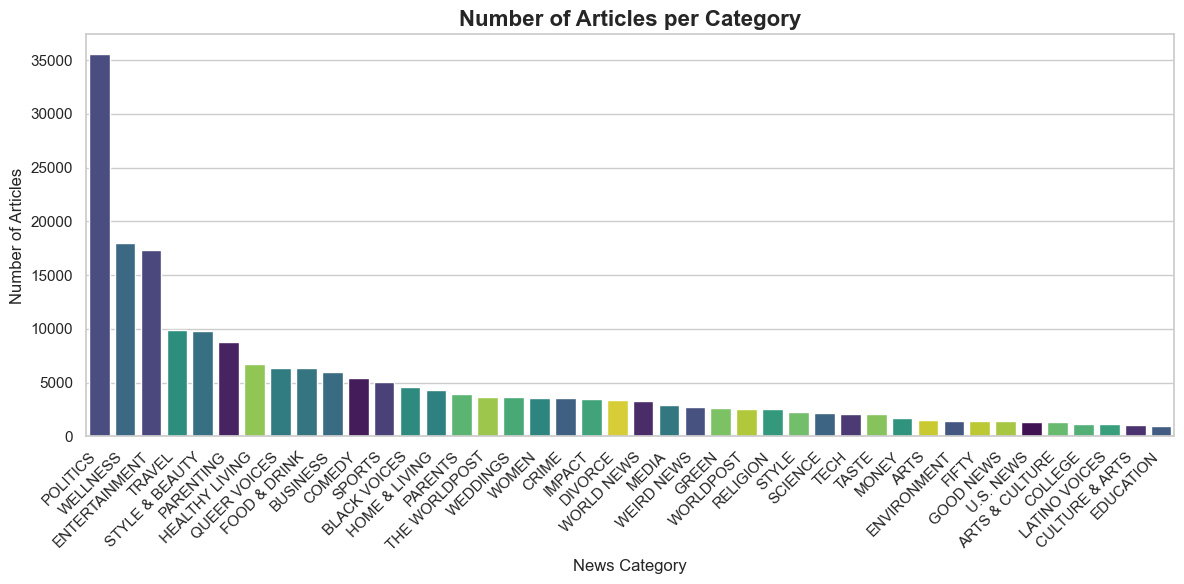

In [54]:
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

sns.countplot(
    data=news,
    x='category',
    hue='category',
    order=news['category'].value_counts().index,
    palette='viridis',
    legend=False
)
plt.xticks(rotation=45, ha='right')
plt.title("Number of Articles per Category", fontsize=16, fontweight='bold')
plt.xlabel("News Category", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.tight_layout()
plt.show()
